# QDS Hacks 2023
X-ecuters — Jan 6-8, 2023

Dataset from Teck: <br>
JSON - https://drive.google.com/file/d/1j-xR5BaXgwGAgUSI6BpNgZ__eUNt-7Vf/view <br>
CSV - https://drive.google.com/file/d/1pPHPwsk2qIO4sNk6VMayLEES6F9JcUr0/view

Goal: <br>
For a mining operation, find ways to move the same amount of material from the shovels to dumps with the least amount of fuel consumed.

In [111]:
# Import required libraries

import json
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

from scipy import stats
from sklearn import model_selection, feature_selection, linear_model, naive_bayes, tree, metrics
from sklearn.feature_selection import SelectKBest, chi2

---

## 1. Data Cleaning and Pre-Processing

In [2]:
# Load data as a DataFrame

df = pd.read_json('../Information/data_group0.json')

In [3]:
# Examine broadly

print(df.shape)
print(df.dtypes)
df.head()

(1928270, 12)
TIMESTAMP        datetime64[ns]
GPSNORTHING             float64
GPSEASTING              float64
GPSELEVATION            float64
FUEL_RATE               float64
STATUS                   object
PAYLOAD                 float64
TRUCK_ID                  int64
TRUCK_TYPE_ID             int64
SHOVEL_ID                 int64
DUMP_ID                   int64
RND                       int64
dtype: object


,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
2,2022-04-03 00:01:04,55334.328779,224524.094341,402.9144,NaN,Empty,0.0,0,0,0,0,0
11,2022-04-03 00:01:22,55250.890875,224568.985459,402.3460,NaN,Empty,0.0,0,0,0,0,0
19,2022-04-03 00:01:38,55236.506152,224491.232652,400.4378,NaN,Empty,0.0,0,0,0,0,0
21,2022-04-03 00:01:42,55252.532868,224465.523704,398.0018,NaN,Empty,0.0,0,0,0,0,0
24,2022-04-03 00:01:48,55288.883906,224411.149771,392.3178,NaN,Empty,0.0,0,0,0,0,0


In [4]:
# Check for duplicated rows

df[df.duplicated()]

,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
34851,2022-04-03 21:01:22,55286.791031,224622.628466,403.4016,NaN,Hauling,NaN,0,0,0,0,0
322389,2022-04-04 01:44:46,55364.946353,224540.054957,402.1836,201.0945,Hauling,NaN,24,3,0,0,0
414895,2022-04-03 19:32:22,55359.116572,224576.130087,402.4678,200.2365,Hauling,NaN,33,3,0,0,0
486571,2022-04-03 20:01:04,55917.604637,224764.623802,356.6304,196.4300,Hauling,NaN,49,3,0,0,0
545535,2022-04-04 01:00:00,56158.601036,224491.709413,271.0862,205.6690,Hauling,286.130,21,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19024264,2022-04-05 06:31:22,55930.742401,227026.833088,202.9594,198.2305,Hauling,NaN,41,3,7,25,0
19060877,2022-04-06 01:27:28,55731.118992,228645.261512,109.7824,196.4315,NON_PRODUCTIVE,0.000,12,3,5,25,0
19101041,2022-04-05 10:23:38,56395.323615,228530.123081,94.7604,196.0000,Empty,0.000,46,3,7,28,0
19173924,2022-04-08 21:12:38,56175.347867,228201.217907,140.1918,NaN,Hauling,248.287,42,4,2,21,0


In [5]:
df.loc[[34850,34851]] # examining duplicates case 1

,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
34850,2022-04-03 21:01:22,55286.791031,224622.628466,403.4016,NaN,Hauling,NaN,0,0,0,0,0
34851,2022-04-03 21:01:22,55286.791031,224622.628466,403.4016,NaN,Hauling,NaN,0,0,0,0,0


In [6]:
df.loc[[322388,322389]] # examining duplicates case 2

,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
322388,2022-04-04 01:44:46,55364.946353,224540.054957,402.1836,201.0945,Hauling,NaN,24,3,0,0,0
322389,2022-04-04 01:44:46,55364.946353,224540.054957,402.1836,201.0945,Hauling,NaN,24,3,0,0,0


In [7]:
# Drop duplicated rows (keep first by default)

df_dropDupes = df.copy()
df_dropDupes.drop_duplicates(inplace=True)
print(df_dropDupes.shape)

(1926432, 12)


In [8]:
# Drop rows with any null values

df_dropNA = df_dropDupes.copy()
df_dropNA.dropna(inplace=True)
print(df_dropNA.shape)

(846050, 12)


In [9]:
# Change Status and IDs to categorical data

col_names = ['STATUS', 'TRUCK_ID', 'TRUCK_TYPE_ID', 'SHOVEL_ID', 'DUMP_ID', 'RND']

for col in col_names:
    df_dropNA[col] = df_dropNA[col].astype('category')

print(df_dropNA.dtypes)

df_cleaned = df_dropNA.copy()
df_cleaned.head()

TIMESTAMP        datetime64[ns]
GPSNORTHING             float64
GPSEASTING              float64
GPSELEVATION            float64
FUEL_RATE               float64
STATUS                 category
PAYLOAD                 float64
TRUCK_ID               category
TRUCK_TYPE_ID          category
SHOVEL_ID              category
DUMP_ID                category
RND                    category
dtype: object


,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
65125,2022-04-03 14:47:16,55034.516453,222824.522779,366.2526,198.7570,Empty,0.0,3,3,0,0,0
65136,2022-04-03 14:47:38,55132.024813,222878.486122,364.5880,201.7380,Empty,0.0,3,3,0,0,0
65141,2022-04-03 14:47:48,55123.098526,222957.701274,364.5474,198.4345,Empty,0.0,3,3,0,0,0
65161,2022-04-03 14:48:28,55248.006549,223379.682400,363.2482,199.5020,Empty,0.0,3,3,0,0,0
65171,2022-04-03 14:48:48,55237.787494,223591.586468,361.6648,196.4355,Empty,0.0,3,3,0,0,0


In [10]:
# Now that the data is cleaned, examine the dataset more closely

print(df_cleaned.describe())
df_cleaned.describe(include='all')

        GPSNORTHING     GPSEASTING   GPSELEVATION      FUEL_RATE  \
count  8.460500e+05  846050.000000  846050.000000  846050.000000   
mean   5.592527e+04  227709.247688     193.291732     199.037725   
std    2.639823e+04    2518.372268      85.593730       9.699030   
min   -5.978350e+06  222469.509778   -1218.000000     196.000000   
25%    5.520000e+04  227532.494718     113.030400     196.501500   
50%    5.602175e+04  228217.765559     187.734400     196.934500   
75%    5.692295e+04  228748.078352     239.012200     199.997000   
max    6.118715e+04  671590.379491     425.934600    1506.700000   

             PAYLOAD  
count  846050.000000  
mean       57.668816  
std       112.115662  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max       629.486000  


/var/folders/yc/yfbtx3d16797zs0w20yxnbg40000gn/T/ipykernel_30487/3575777309.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_cleaned.describe(include='all')


,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
count,846050,8.460500e+05,846050.000000,846050.000000,846050.000000,846050,846050.000000,846050.0,846050.0,846050.0,846050.0,846050.0
unique,317011,NaN,NaN,NaN,NaN,9,NaN,51.0,3.0,9.0,36.0,1.0
top,2022-04-09 14:49:34,NaN,NaN,NaN,NaN,Empty,NaN,30.0,3.0,1.0,1.0,0.0
freq,14,NaN,NaN,NaN,NaN,290093,NaN,29596.0,652011.0,237900.0,240777.0,846050.0
first,2022-04-03 00:01:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-04-10 23:59:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.592527e+04,227709.247688,193.291732,199.037725,NaN,57.668816,NaN,NaN,NaN,NaN,NaN
std,NaN,2.639823e+04,2518.372268,85.593730,9.699030,NaN,112.115662,NaN,NaN,NaN,NaN,NaN
min,NaN,-5.978350e+06,222469.509778,-1218.000000,196.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,5.520000e+04,227532.494718,113.030400,196.501500,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


In [11]:
df_cleaned

,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
65125,2022-04-03 14:47:16,55034.516453,222824.522779,366.2526,198.7570,Empty,0.0,3,3,0,0,0
65136,2022-04-03 14:47:38,55132.024813,222878.486122,364.5880,201.7380,Empty,0.0,3,3,0,0,0
65141,2022-04-03 14:47:48,55123.098526,222957.701274,364.5474,198.4345,Empty,0.0,3,3,0,0,0
65161,2022-04-03 14:48:28,55248.006549,223379.682400,363.2482,199.5020,Empty,0.0,3,3,0,0,0
65171,2022-04-03 14:48:48,55237.787494,223591.586468,361.6648,196.4355,Empty,0.0,3,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19287754,2022-04-03 01:33:42,57653.850706,228928.973189,224.4368,196.5475,NON_PRODUCTIVE,0.0,32,3,4,4,0
19287771,2022-04-03 01:34:16,57654.499485,228929.729172,224.4368,196.5395,NON_PRODUCTIVE,0.0,32,3,4,4,0
19287788,2022-04-03 01:34:50,57655.888975,228929.391882,226.7104,196.5405,NON_PRODUCTIVE,0.0,32,3,4,4,0
19287790,2022-04-03 01:34:54,57656.488225,228929.220970,227.4412,196.6360,NON_PRODUCTIVE,0.0,32,3,4,4,0


In [124]:
df_cleaned.to_csv("data_group0_out.csv")

---

## 2. Data Analysis

In [13]:
df_copy = df_cleaned.copy()

### Getting the unique truck IDs and mapping them to the truck type

In [62]:
print(len(df_copy['TRUCK_ID'].unique()))

truck_list = np.sort(df_copy['TRUCK_ID'].unique()).tolist()
print(truck_list)

51
[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 43, 44, 46, 47, 49, 50, 51, 53, 54, 55, 56, 57, 61, 62, 63, 66, 67, 68, 69]


In [64]:
type_for_each_truck = {}

for truck in truck_list:
    type_for_each_truck[truck] = df_copy.loc[df_copy['TRUCK_ID'] == truck]['TRUCK_TYPE_ID'].unique()
    
type_for_each_truck

{1: [1]
 Categories (3, int64): [0, 1, 3],
 3: [3]
 Categories (3, int64): [0, 1, 3],
 4: [3]
 Categories (3, int64): [0, 1, 3],
 5: [3]
 Categories (3, int64): [0, 1, 3],
 6: [3]
 Categories (3, int64): [0, 1, 3],
 8: [3]
 Categories (3, int64): [0, 1, 3],
 9: [3]
 Categories (3, int64): [0, 1, 3],
 11: [3]
 Categories (3, int64): [0, 1, 3],
 12: [3]
 Categories (3, int64): [0, 1, 3],
 13: [3]
 Categories (3, int64): [0, 1, 3],
 14: [3]
 Categories (3, int64): [0, 1, 3],
 15: [3]
 Categories (3, int64): [0, 1, 3],
 17: [3]
 Categories (3, int64): [0, 1, 3],
 18: [3]
 Categories (3, int64): [0, 1, 3],
 21: [3]
 Categories (3, int64): [0, 1, 3],
 22: [3]
 Categories (3, int64): [0, 1, 3],
 23: [3]
 Categories (3, int64): [0, 1, 3],
 24: [3]
 Categories (3, int64): [0, 1, 3],
 25: [3]
 Categories (3, int64): [0, 1, 3],
 26: [1]
 Categories (3, int64): [0, 1, 3],
 27: [3]
 Categories (3, int64): [0, 1, 3],
 28: [3]
 Categories (3, int64): [0, 1, 3],
 30: [1]
 Categories (3, int64): [0, 1,

### Finding truck types that carry a payload of 0

In [77]:
df_zeroPayload = df_copy.loc[(df_copy['PAYLOAD'] == 0.0)]

print("Records where TRUCK TYPE 0 has 0 payload: " + str(len(df_zeroPayload[df_zeroPayload['TRUCK_TYPE_ID'] == 0])))
print("Total records of TRUCK TYPE 0: " + str(len(df_copy[df_copy['TRUCK_TYPE_ID'] == 0])))
print(len(df_zeroPayload[df_zeroPayload['TRUCK_TYPE_ID'] == 0]) / len(df_copy[df_copy['TRUCK_TYPE_ID'] == 0]))
print()
print("Records where TRUCK TYPE 1 has 0 payload: " + str(len(df_zeroPayload[df_zeroPayload['TRUCK_TYPE_ID'] == 1])))
print("Total records of TRUCK TYPE 1: " + str(len(df_copy[df_copy['TRUCK_TYPE_ID'] == 1])))
print(len(df_zeroPayload[df_zeroPayload['TRUCK_TYPE_ID'] == 1]) / len(df_copy[df_copy['TRUCK_TYPE_ID'] == 1]))
print()
print("Records where TRUCK TYPE 3 has 0 payload: " + str(len(df_zeroPayload[df_zeroPayload['TRUCK_TYPE_ID'] == 3])))
print("Total records of TRUCK TYPE 3: " + str(len(df_copy[df_copy['TRUCK_TYPE_ID'] == 3])))
print(len(df_zeroPayload[df_zeroPayload['TRUCK_TYPE_ID'] == 3]) / len(df_copy[df_copy['TRUCK_TYPE_ID'] == 3]))

Records where TRUCK TYPE 0 has 0 payload: 392
Total records of TRUCK TYPE 0: 392
1.0

Records where TRUCK TYPE 1 has 0 payload: 124947
Total records of TRUCK TYPE 1: 193647
0.645230754930363

Records where TRUCK TYPE 3 has 0 payload: 531735
Total records of TRUCK TYPE 3: 652011
0.8155307195737496


### Separating each run into a DataFrame

In [78]:
index = pd.Index(range(0, 846050, 1))
df_new = df_copy.copy()
df_new = df_new.set_index(index)
df_new

,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
0,2022-04-03 14:47:16,55034.516453,222824.522779,366.2526,198.7570,Empty,0.0,3,3,0,0,0
1,2022-04-03 14:47:38,55132.024813,222878.486122,364.5880,201.7380,Empty,0.0,3,3,0,0,0
2,2022-04-03 14:47:48,55123.098526,222957.701274,364.5474,198.4345,Empty,0.0,3,3,0,0,0
3,2022-04-03 14:48:28,55248.006549,223379.682400,363.2482,199.5020,Empty,0.0,3,3,0,0,0
4,2022-04-03 14:48:48,55237.787494,223591.586468,361.6648,196.4355,Empty,0.0,3,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
846045,2022-04-03 01:33:42,57653.850706,228928.973189,224.4368,196.5475,NON_PRODUCTIVE,0.0,32,3,4,4,0
846046,2022-04-03 01:34:16,57654.499485,228929.729172,224.4368,196.5395,NON_PRODUCTIVE,0.0,32,3,4,4,0
846047,2022-04-03 01:34:50,57655.888975,228929.391882,226.7104,196.5405,NON_PRODUCTIVE,0.0,32,3,4,4,0
846048,2022-04-03 01:34:54,57656.488225,228929.220970,227.4412,196.6360,NON_PRODUCTIVE,0.0,32,3,4,4,0


In [113]:
df_collection_run = []

temp_start_index = 0

# creates a list of tuples of runs
for index, row in df_new.iterrows():
    if (index < 846049) and ((df_new.iloc[index]["TRUCK_ID"] != df_new.iloc[index + 1]["TRUCK_ID"]) or (df_new.iloc[index]["TIMESTAMP"] > df_new.iloc[index + 1]["TIMESTAMP"]) or(((np.datetime64(df_new.iloc[index + 1]["TIMESTAMP"]) - np.datetime64(df_new.iloc[index]["TIMESTAMP"]))/np.timedelta64(1, 'm')) > 10)):
        df_collection_run.append(df_new.iloc[temp_start_index:index+1])
        temp_start_index = index + 1

In [114]:
fuel_consumption = []
counter = 0

for df in df_collection_run:
    avg_fuel_rate = sum(df['FUEL_RATE']) / len(df)
    
    start_time = df.iloc[0]["TIMESTAMP"]
    end_time = df.iloc[-1]["TIMESTAMP"]

    time_diff = np.datetime64(end_time) - np.datetime64(start_time)
    time_diff_in_hours = time_diff / np.timedelta64(1, 'h')
    
    fuel_consumption.append((counter,(avg_fuel_rate * time_diff_in_hours)))
                            
    counter = counter + 1
    
fuel_consumption

[(0, 62.8398065079365),
 (1, 592.163229078196),
 (2, 195.7218780167264),
 (3, 1338.3283802603069),
 (4, 259.50771491386723),
 (5, 76.05693234567903),
 (6, 185.057452534415),
 (7, 528.1264188713916),
 (8, 635.0372246612471),
 (9, 1.428199861111111),
 (10, 154.05578604235419),
 (11, 54.781867283950625),
 (12, 24.88036790123457),
 (13, 251.3340292152778),
 (14, 339.38555151041646),
 (15, 256.0845119205299),
 (16, 597.1873095152683),
 (17, 56.09512152222221),
 (18, 1807.556131577986),
 (19, 28.239282380952385),
 (20, 1437.9643355384658),
 (21, 452.75578684088686),
 (22, 42.064843333333336),
 (23, 38.43800688888889),
 (24, 83.58580812368974),
 (25, 29.57793523504273),
 (26, 941.062913024958),
 (27, 74.8386712689394),
 (28, 194.0164685786435),
 (29, 211.6395658658658),
 (30, 27.394214409722224),
 (31, 36.313564988888885),
 (32, 35.77143666666667),
 (33, 195.1905526411658),
 (34, 385.5931913703706),
 (35, 406.69480450167487),
 (36, 147.63654921259837),
 (37, 11.181797948717948),
 (38, 21.4667

In [123]:
run_time_elapsed = []

for run in fuel_consumption:
    start_time = df_collection_run[run[0]].iloc[0]['TIMESTAMP']
    end_time = df_collection_run[run[0]].iloc[-1]['TIMESTAMP']
    
    time_diff = np.datetime64(end_time) - np.datetime64(start_time)
    converted_time_diff = time_diff / np.timedelta64(1, 'm')
    
    run_time_elapsed.append(converted_time_diff)

fuel_consump_list = []

for item in fuel_consumption:
    fuel_consump_list.append(item[1])

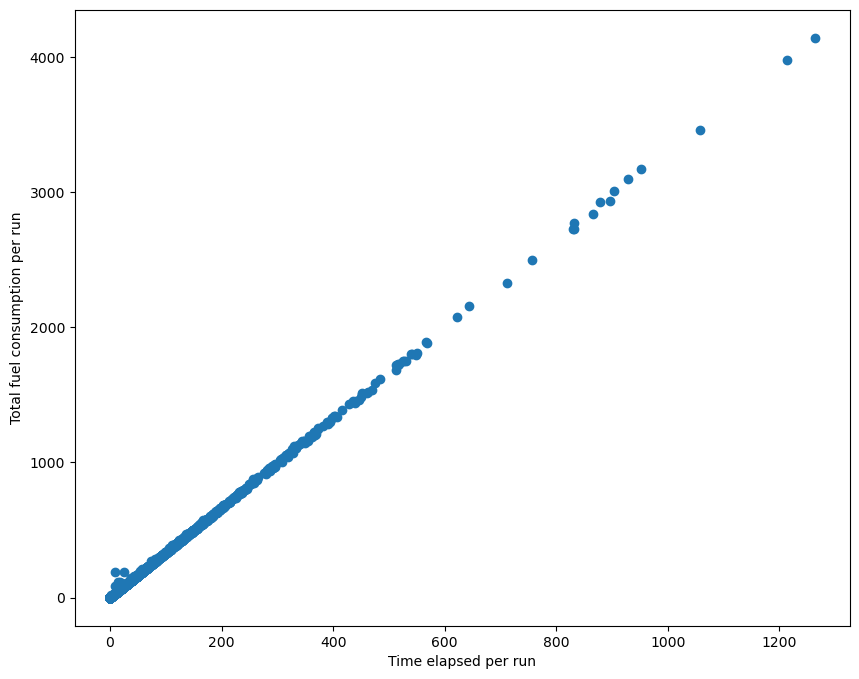

In [122]:
plt.figure()
plt.scatter(run_time_elapsed, fuel_consump_list)
plt.xlabel('Time elapsed per run')
plt.ylabel('Total fuel consumption per run')
plt.show()

### Examining all statuses (one haul cycle)

In [14]:
df_copy['STATUS'].unique()

['Empty', 'Queue At LU', 'Spot at LU', 'Truck Loading', 'Queuing at Dump', 'Dumping', 'NON_PRODUCTIVE', 'Wenco General Production', 'Hauling']
Categories (9, object): ['Dumping', 'Empty', 'Hauling', 'NON_PRODUCTIVE', ..., 'Queuing at Dump', 'Spot at LU', 'Truck Loading', 'Wenco General Production']

### Isolating the "NON_PRODUCTIVE" status (idling/delays)

Observation: the idling percentage is ~27%, which is about a quarter of the time

In [52]:
df_nonproductive = df_copy.loc[df_copy['STATUS'] == 'NON_PRODUCTIVE' & df_copy['FUEL_RATE'] > 0]
df_nonproductive

,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
67595,2022-04-03 16:31:24,56252.860987,225101.346979,354.9252,196.2755,NON_PRODUCTIVE,0.0,3,3,0,0,0
67597,2022-04-03 16:31:28,56252.519065,225101.049942,354.3568,196.3160,NON_PRODUCTIVE,0.0,3,3,0,0,0
67601,2022-04-03 16:31:36,56251.510413,225100.246401,352.6922,196.2755,NON_PRODUCTIVE,0.0,3,3,0,0,0
67605,2022-04-03 16:31:44,56250.897493,225099.637715,351.6366,196.2805,NON_PRODUCTIVE,0.0,3,3,0,0,0
67610,2022-04-03 16:31:54,56250.632283,225099.157350,351.4742,196.2370,NON_PRODUCTIVE,0.0,3,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19287749,2022-04-03 01:33:32,57653.985381,228928.856588,225.3706,196.5525,NON_PRODUCTIVE,0.0,32,3,4,4,0
19287754,2022-04-03 01:33:42,57653.850706,228928.973189,224.4368,196.5475,NON_PRODUCTIVE,0.0,32,3,4,4,0
19287771,2022-04-03 01:34:16,57654.499485,228929.729172,224.4368,196.5395,NON_PRODUCTIVE,0.0,32,3,4,4,0
19287788,2022-04-03 01:34:50,57655.888975,228929.391882,226.7104,196.5405,NON_PRODUCTIVE,0.0,32,3,4,4,0


In [60]:
col_names = ['TRUCK_ID', 'TRUCK_TYPE_ID']

for col in col_names:
    df_nonproductive[col] = df_nonproductive[col].astype('int64')

df_nonproductive.describe(include='all')

/var/folders/yc/yfbtx3d16797zs0w20yxnbg40000gn/T/ipykernel_30487/68284702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonproductive[col] = df_nonproductive[col].astype('int64')
/var/folders/yc/yfbtx3d16797zs0w20yxnbg40000gn/T/ipykernel_30487/68284702.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_nonproductive.describe(include='all')


,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
count,231455,2.314550e+05,231455.000000,231455.000000,231455.000000,231455,231455.0,231455.000000,231455.000000,231455.0,231455.0,231455.0
unique,144198,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,9.0,36.0,1.0
top,2022-04-06 13:33:08,NaN,NaN,NaN,NaN,NON_PRODUCTIVE,NaN,NaN,NaN,1.0,1.0,0.0
freq,10,NaN,NaN,NaN,NaN,231455,NaN,NaN,NaN,54423.0,61911.0,231455.0
first,2022-04-03 00:14:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-04-10 23:59:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.584250e+04,227632.009734,207.780110,196.938290,NaN,0.0,31.109257,2.635091,NaN,NaN,NaN
std,NaN,4.546358e+04,3745.372741,93.421878,17.152843,NaN,0.0,17.687146,0.773026,NaN,NaN,NaN
min,NaN,-5.978350e+06,222545.908335,-1218.000000,196.000000,NaN,0.0,1.000000,0.000000,NaN,NaN,NaN
25%,NaN,5.521501e+04,227492.072965,117.131000,196.382000,NaN,0.0,17.000000,3.000000,NaN,NaN,NaN


In [61]:
nonproductive_percentage = (len(df_nonproductive)/len(df_copy)) * 100
print(str(nonproductive_percentage) + '%')

27.35713019325099%


### Looking at data from shovel 0 to dump 0

Observation: payload values are all 0

In [17]:
shovel0_dump0 = df_copy.loc[(df_copy['SHOVEL_ID'] == 0) & (df_copy['DUMP_ID'] == 0)]
shovel0_dump0.describe(include='all')

/var/folders/yc/yfbtx3d16797zs0w20yxnbg40000gn/T/ipykernel_30487/2178381648.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  shovel0_dump0.describe(include='all')


,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
count,25719,2.571900e+04,25719.000000,25719.000000,25719.000000,25719,25719.0,25719.0,25719.0,25719.0,25719.0,25719.0
unique,21723,NaN,NaN,NaN,NaN,8,NaN,21.0,1.0,1.0,1.0,1.0
top,2022-04-03 03:11:18,NaN,NaN,NaN,NaN,NON_PRODUCTIVE,NaN,41.0,3.0,0.0,0.0,0.0
freq,5,NaN,NaN,NaN,NaN,10165,NaN,4328.0,25719.0,25719.0,25719.0,25719.0
first,2022-04-03 00:09:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-04-10 22:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.605035e+04,225015.478642,351.570562,197.388450,NaN,0.0,NaN,NaN,NaN,NaN,NaN
std,NaN,3.763593e+04,2827.972880,36.003732,1.733737,NaN,0.0,NaN,NaN,NaN,NaN,NaN
min,NaN,-5.978350e+06,222550.323246,-1218.000000,196.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN
25%,NaN,5.586887e+04,224736.837057,329.103600,196.506500,NaN,0.0,NaN,NaN,NaN,NaN,NaN


### Looking at data from shovel 1 to dump 1

Observation: some payload values are none-0

In [18]:
shovel1_dump1 = df_copy.loc[(df_copy['SHOVEL_ID'] == 1) & (df_copy['DUMP_ID'] == 1)]
shovel1_dump1.describe(include='all')

/var/folders/yc/yfbtx3d16797zs0w20yxnbg40000gn/T/ipykernel_30487/1112174425.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  shovel1_dump1.describe(include='all')


,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
count,100968,1.009680e+05,100968.000000,100968.000000,100968.00000,100968,100968.000000,100968.0,100968.0,100968.0,100968.0,100968.0
unique,80514,NaN,NaN,NaN,NaN,8,NaN,48.0,2.0,1.0,1.0,1.0
top,2022-04-06 16:00:02,NaN,NaN,NaN,NaN,Hauling,NaN,36.0,3.0,1.0,1.0,0.0
freq,7,NaN,NaN,NaN,NaN,36621,NaN,8235.0,51173.0,100968.0,100968.0,100968.0
first,2022-04-03 00:01:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-04-10 23:59:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.506398e+04,228196.489894,158.569066,200.09526,NaN,107.155411,NaN,NaN,NaN,NaN,NaN
std,NaN,1.904620e+04,1490.119546,55.907698,6.09368,NaN,145.322978,NaN,NaN,NaN,NaN,NaN
min,NaN,-5.978350e+06,222645.228386,-1218.000000,196.00000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,5.366249e+04,227669.179900,101.743600,196.54500,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


### Drop all records where payload = 0

In [19]:
df_dropZeroes = df_copy.loc[(df_copy['PAYLOAD'] > 0)]
df_dropZeroes

,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
545326,2022-04-04 00:53:04,57067.062646,224628.640788,190.1298,198.4070,Hauling,286.130,21,3,3,0,0
545330,2022-04-04 00:53:12,57076.464211,224648.069297,190.6982,197.8905,Hauling,286.130,21,3,3,0,0
545333,2022-04-04 00:53:18,57094.988793,224662.585234,192.4440,202.2155,Hauling,286.130,21,3,3,0,0
545338,2022-04-04 00:53:28,57140.311558,224671.341439,194.0274,204.8810,Hauling,286.130,21,3,3,0,0
545357,2022-04-04 00:54:06,57270.154964,224868.941533,195.6108,205.2720,Hauling,286.130,21,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19257726,2022-04-04 14:07:54,54872.453497,228798.833907,212.6628,197.8565,Hauling,351.663,36,1,2,23,0
19257763,2022-04-04 14:09:08,54674.642311,228747.667719,206.7352,196.9865,Hauling,351.663,36,1,2,23,0
19257771,2022-04-04 14:09:24,54643.293187,228738.396373,203.8526,196.9160,Hauling,351.663,36,1,2,23,0
19257793,2022-04-04 14:10:08,54558.852517,228723.248641,201.3354,198.0465,Hauling,351.663,36,1,2,23,0


### Getting unique payload values and finding sum

In [20]:
#df_dropZeroes.loc[(df_dropZeroes['TRUCK_ID'] == 1) & (df_dropZeroes['SHOVEL_ID'] == 1) & (df_dropZeroes['DUMP_ID'] == 10)]

In [21]:
sum(df_dropZeroes['PAYLOAD'].unique())

235578.21300000002

### Finding the payload sum for each shovel to dump combination

In [22]:
# Create empty dictionary to hold shovel-dump combination (keys) and payload sum (values)

payload_dict = {}

# Loop through each unique value of shovel and dump to create combinations and calculate payload sum from unique payload values

for shovel in np.sort(df_copy['SHOVEL_ID'].unique()).tolist():
    for dump in np.sort(df_copy['DUMP_ID'].unique()).tolist():
        temp_str = str(shovel) + "-" + str(dump)
        temp_df = df_copy.loc[(df_copy['SHOVEL_ID'] == shovel) & (df_copy['DUMP_ID'] == dump)]
        payload_dict.update({temp_str: sum(temp_df['PAYLOAD'].unique())})

payload_dict

{'0-0': 0.0,
 '0-1': 0,
 '0-2': 0,
 '0-3': 0,
 '0-4': 0,
 '0-5': 0.0,
 '0-6': 0,
 '0-7': 0,
 '0-8': 0.0,
 '0-9': 0,
 '0-10': 0.0,
 '0-11': 0,
 '0-12': 0,
 '0-13': 0,
 '0-14': 0,
 '0-15': 0,
 '0-16': 0,
 '0-17': 0,
 '0-18': 0,
 '0-19': 0,
 '0-20': 0,
 '0-21': 0,
 '0-22': 0,
 '0-23': 0,
 '0-24': 0,
 '0-25': 0,
 '0-26': 0,
 '0-27': 0,
 '0-28': 0,
 '0-29': 0,
 '0-30': 0,
 '0-31': 0,
 '0-32': 0,
 '0-33': 0,
 '0-34': 0,
 '0-35': 0,
 '1-0': 0,
 '1-1': 53306.019,
 '1-2': 33008.325999999994,
 '1-3': 0,
 '1-4': 0,
 '1-5': 0,
 '1-6': 28219.802000000007,
 '1-7': 15358.72,
 '1-8': 1205.4379999999999,
 '1-9': 37435.957,
 '1-10': 7602.750999999998,
 '1-11': 32482.215999999997,
 '1-12': 9986.86,
 '1-13': 0,
 '1-14': 0,
 '1-15': 0,
 '1-16': 0,
 '1-17': 0,
 '1-18': 0,
 '1-19': 0,
 '1-20': 0,
 '1-21': 0,
 '1-22': 0,
 '1-23': 0,
 '1-24': 0,
 '1-25': 0,
 '1-26': 954.3820000000001,
 '1-27': 0,
 '1-28': 0,
 '1-29': 0,
 '1-30': 0,
 '1-31': 0,
 '1-32': 4327.947,
 '1-33': 0.0,
 '1-34': 0,
 '1-35': 557.492,
 '2-

In [23]:
# Remove key-value pairs where the value is 0

payload_dict_dropZeroes = {x:y for x,y in payload_dict.items() if y!=0}
payload_dict_dropZeroes

{'1-1': 53306.019,
 '1-2': 33008.325999999994,
 '1-6': 28219.802000000007,
 '1-7': 15358.72,
 '1-8': 1205.4379999999999,
 '1-9': 37435.957,
 '1-10': 7602.750999999998,
 '1-11': 32482.215999999997,
 '1-12': 9986.86,
 '1-26': 954.3820000000001,
 '1-32': 4327.947,
 '1-35': 557.492,
 '2-1': 40394.17200000001,
 '2-2': 32423.143999999986,
 '2-6': 2747.7709999999997,
 '2-10': 280.592,
 '2-11': 8588.515000000001,
 '2-23': 351.663,
 '3-0': 286.13,
 '3-3': 1881.074,
 '3-5': 23802.323999999997,
 '3-8': 1417.728,
 '3-10': 4150.731,
 '3-16': 10160.383999999995,
 '3-24': 1114.061,
 '6-1': 64539.759699999995,
 '6-2': 28523.376699999997,
 '6-6': 1292.1077,
 '6-7': 1382.9308999999998,
 '6-8': 1240.5120000000002,
 '6-9': 11307.3961,
 '6-11': 43743.73900000001,
 '6-15': 9270.4274,
 '6-17': 2300.3005999999996,
 '6-18': 7464.301000000001,
 '6-19': 12940.921499999997,
 '6-20': 5262.207600000001,
 '6-26': 91.5616,
 '6-27': 359.1393,
 '6-31': 954.4743,
 '6-32': 18311.212399999997}

<AxesSubplot:>

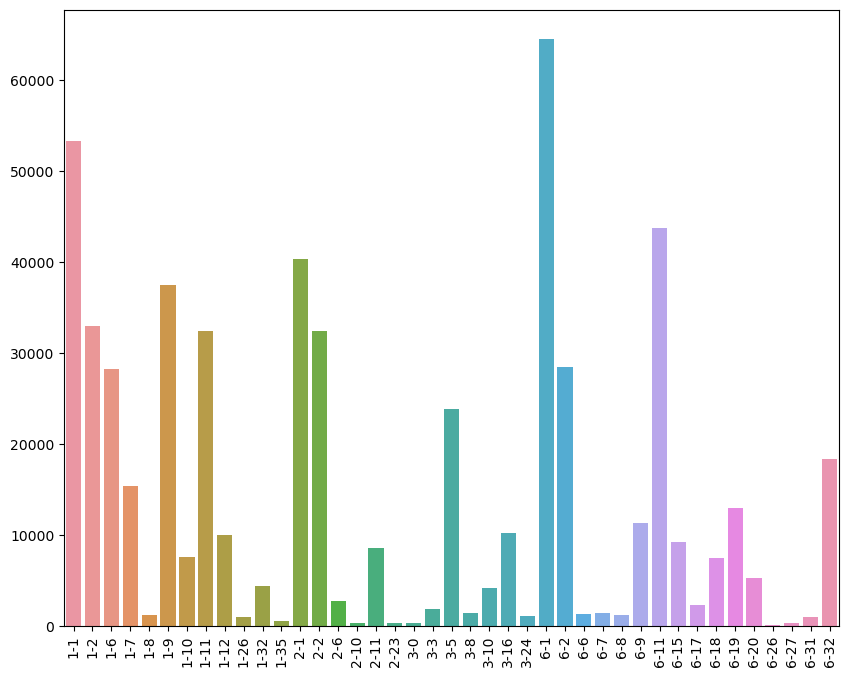

In [24]:
keys = list(payload_dict_dropZeroes.keys())
vals = [float(payload_dict_dropZeroes[k]) for k in keys]

payload_plot = sns.barplot(x=keys, y=vals)
payload_plot.set_xticklabels(payload_plot.get_xticklabels(), rotation=90)
payload_plot

### Correlation analysis

In [25]:
df_copy.corr()

,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,PAYLOAD
GPSNORTHING,1.000000,-0.758233,0.070393,-0.001846,-0.008219
GPSEASTING,-0.758233,1.000000,-0.414013,0.002494,0.004730
GPSELEVATION,0.070393,-0.414013,1.000000,0.005249,-0.018544
FUEL_RATE,-0.001846,0.002494,0.005249,1.000000,0.276234
PAYLOAD,-0.008219,0.004730,-0.018544,0.276234,1.000000


<AxesSubplot:>

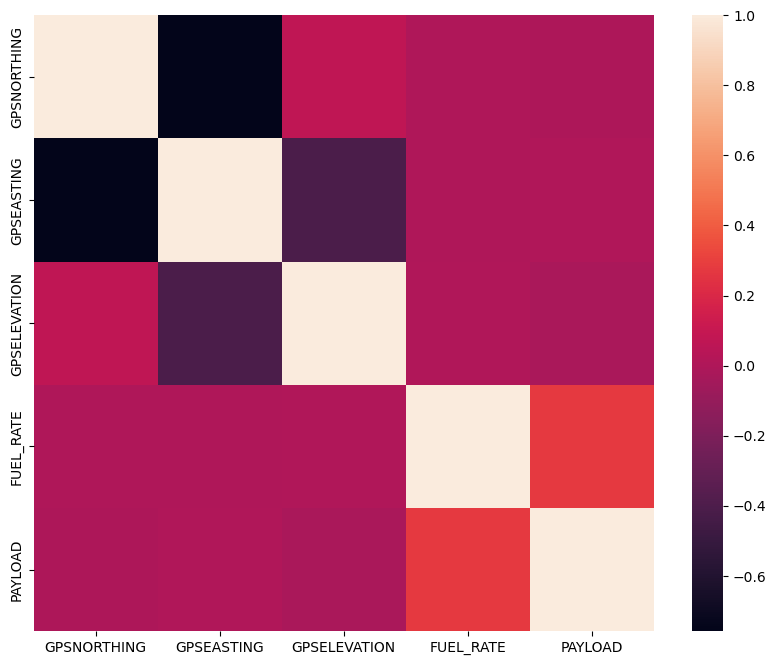

In [26]:
sns.heatmap(df_copy.corr())

In [28]:
# Shapiro-Wilk tests for numerical predictors

print(stats.shapiro(df_copy['GPSNORTHING']))
print(stats.shapiro(df_copy['GPSEASTING']))
print(stats.shapiro(df_copy['GPSELEVATION']))
print(stats.shapiro(df_copy['FUEL_RATE']))

ShapiroResult(statistic=0.00784987211227417, pvalue=0.0)
ShapiroResult(statistic=0.34157800674438477, pvalue=0.0)
ShapiroResult(statistic=0.9215213060379028, pvalue=0.0)
ShapiroResult(statistic=0.12600916624069214, pvalue=0.0)


/Users/tliang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [41]:
df_categorical = df_copy.filter(['FUEL_RATE','STATUS','TRUCK_ID', 'TRUCK_TYPE_ID'], axis=1)

df_categorical = pd.get_dummies(df_categorical, columns=['STATUS','TRUCK_ID', 'TRUCK_TYPE_ID'], 
                                                prefix=['status', 'truck', 'truckType'])

df_categorical['FR_LT_AVG'] = 1
df_categorical.loc[df_categorical['FUEL_RATE'] >= 199.037725, 'FR_LT_AVG'] = 0

df_categorical

,FUEL_RATE,status_Dumping,status_Empty,status_Hauling,status_NON_PRODUCTIVE,status_Queue At LU,status_Queuing at Dump,status_Spot at LU,status_Truck Loading,status_Wenco General Production,truck_1,truck_3,truck_4,truck_5,truck_6,truck_8,truck_9,truck_11,truck_12,truck_13,truck_14,truck_15,truck_17,truck_18,truck_21,truck_22,truck_23,truck_24,truck_25,truck_26,truck_27,truck_28,truck_30,truck_31,truck_32,truck_33,truck_34,truck_35,truck_36,truck_37,truck_39,truck_41,truck_43,truck_44,truck_46,truck_47,truck_49,truck_50,truck_51,truck_53,truck_54,truck_55,truck_56,truck_57,truck_61,truck_62,truck_63,truck_66,truck_67,truck_68,truck_69,truckType_0,truckType_1,truckType_3,FR_LT_AVG
65125,198.7570,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
65136,201.7380,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
65141,198.4345,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
65161,199.5020,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
65171,196.4355,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19287754,196.5475,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
19287771,196.5395,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
19287788,196.5405,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
19287790,196.6360,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


<AxesSubplot:xlabel='Predictor', ylabel='Score'>

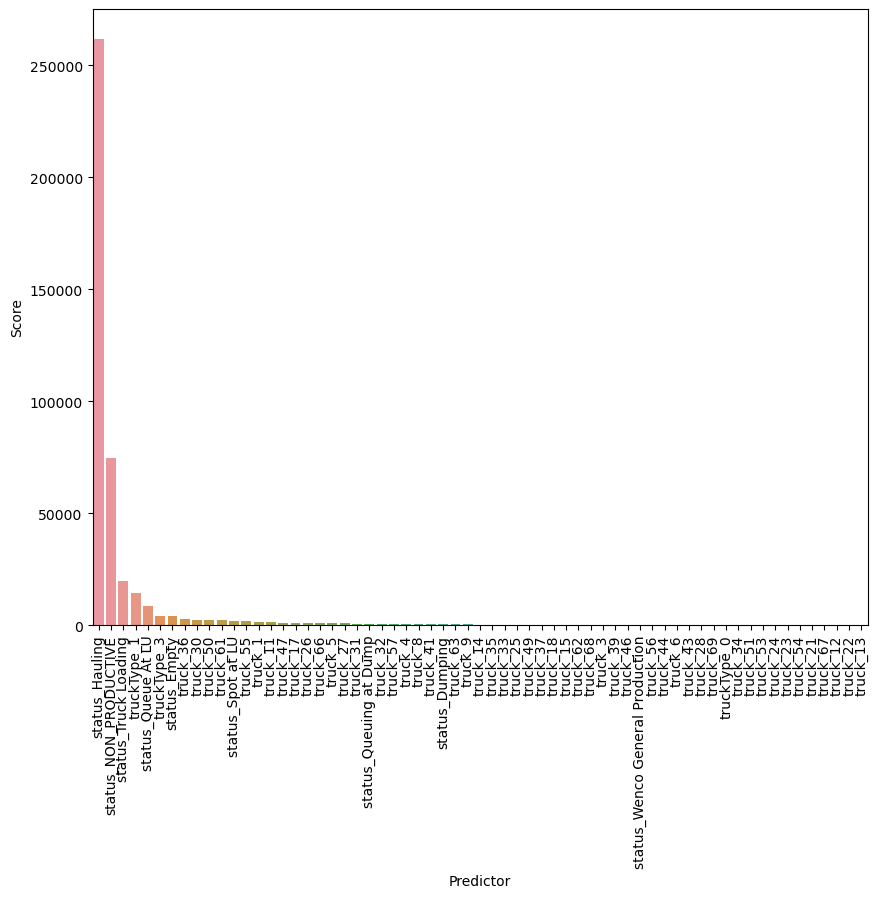

In [48]:
# Chi-squared test for categorical predictors

X_chi2 = df_categorical.iloc[:,1:-1]
y_chi2 = df_categorical['FR_LT_AVG']

df_chi2 = SelectKBest(chi2, k='all')
df_chi2.fit(X_chi2, y_chi2)

chi2_scores = pd.DataFrame({'Predictor': X_chi2.columns,'Score': df_chi2.scores_})
chi2_scores.sort_values(by='Score', ascending=False, inplace=True)

#print(chi2_scores)

chi2_plot = sns.barplot(x=chi2_scores['Predictor'], y=chi2_scores['Score'])
chi2_plot.set_xticklabels(chi2_plot.get_xticklabels(), rotation=90)
chi2_plot

### Making DataFrames for each truck where the status is "NON_PRODUCTIVE"

In [ ]:
df_idle = {}

for truck in truck_list:
    df_idle[truck] = df_copy.loc[(df_copy['STATUS'] == 'NON_PRODUCTIVE') & (df_copy['TRUCK_ID'] == truck)]

df_idle[1].describe(include='all')

### Making DataFrames for each truck in general

In [ ]:
df_collection = {}

for truck in truck_list:
    df_collection[truck] = df_copy.loc[(df_copy['TRUCK_ID'] == truck)]

df_collection[1].describe(include='all')